In [1]:
import uuid
import os
from dotenv import load_dotenv
from function import State, retrieve, evaluate_document, generate, transform_query, web_search, decide_next_step, update_history, retrieve_memory
from conversationMemory import ConservationMemory
from Retriever_memory import SemanticMemoryRetriever
from langgraph.graph import START, END , StateGraph
from format import format_response_for_display


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Admin\Desktop\medical_rag\pdf_retriever.py:11: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding = HuggingFaceEmbeddings(


The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
c:\Users\Admin\Desktop\medical_rag\function.py:5: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from agent import retrieve_grader, question_rewriter


Error loading history : Expecting value: line 1 column 1 (char 0)


In [2]:
memory = ConservationMemory()
semantic_memory = SemanticMemoryRetriever()
semantic_memory.add_memory(memory.get_all_history())


Error loading history : Expecting value: line 1 column 1 (char 0)


In [3]:
workflow = StateGraph(State)
workflow.add_node("retriever_memory", retrieve_memory)
workflow.add_node("retriever", retrieve)
workflow.add_node("grade_document", evaluate_document)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)
workflow.add_node("web_search_tool", web_search)
workflow.add_node("update_history", update_history)

workflow.add_edge(START, "retriever_memory")
workflow.add_edge("retriever_memory", "retriever")
workflow.add_edge("retriever", "grade_document")
workflow.add_conditional_edges(
    "grade_document",
    decide_next_step,
    {
        "transform_query": "transform_query",
        "generate":"generate"
    }
)
workflow.add_edge("transform_query", "web_search_tool")
workflow.add_edge("web_search_tool", "generate")
workflow.add_edge("generate", "update_history")
workflow.add_edge("update_history", END)

app = workflow.compile()

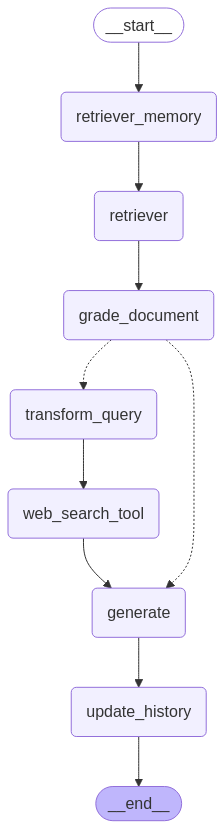

In [4]:
from IPython.display import Image, display
try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
def chat_with_rag():
    print("Chat with the Memory-Enhanced RAG system (type 'exit' to quit, 'clear' to clear current session)")
    chat_history = memory.get_recent_history()
    
    print(f"Loaded {len(memory.get_all_history())} previous interactions from memory")
    
    while True:
        user_input = input("You: ")
        
        if user_input.lower() == 'exit':
            break
        elif user_input.lower() == 'clear':
            memory.clear_current_session()
            chat_history = []
            print("Current session cleared.")
            continue
        
        initial_state = {
            "question": user_input,
            "chat_history": chat_history,
            "document": [],  
            "generation": "", 
            "web_search": "no",  
            "memory_context": ""  
        }
        
        for output in app.stream(initial_state):
            for key, value in output.items():
                if key == "update_history":
                    chat_history = value.get("chat_history", [])
                    print(f"Assistant: {value.get('generation', '')}")
        print()

if __name__ == "__main__":
    chat_with_rag() 

Chat with the Memory-Enhanced RAG system (type 'exit' to quit, 'clear' to clear current session)
Loaded 0 previous interactions from memory
---RETRIEVING MEMORIES HISTORY---
Retrieved 1 relevant memories

=== DOCUMENT RETRIEVAL PHASE ===
1. Processing query...
📝 Query: 'provide information about section : Electromagnetic Compatibility (EMC)'

2. Searching PDF documents...
Loading existing vector database...
Successfully loaded existing vector database
📚 Retrieved 5 documents from database

Document 1:
Preview: Electromagnetic Compatibility
5808972-1EN Rev.8 (January 2024)  13-1
© 2024 GE HealthCare 
Chapter 1...

Document 2:
Preview: Electromagnetic Compatibility
5808972-1EN Rev.8 (January 2024)  13-9
© 2024 GE HealthCare 
The table...

Document 3:
Preview: 2:2014.
− Detailed information concerning Electromagnetic Compatibility can be found in the Electrom...

Document 4:
Preview: Electromagnetic Compatibility
5808972-1EN Rev.8 (January 2024)  13-3
© 2024 GE HealthCare 
NOTE: The...

D